<a href="https://colab.research.google.com/github/LSDtopotools/lsdtt_notebooks/blob/master/lsdtopotools/basic_examples/getting_USGS_data_into_lsdtopotools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting USGS data from opentopography into lsdtopotools


Last updated by Simon M. Mudd on 16/06/2023

In this notebook I will show you how to process USGS 10m data from OpenTopography for input into lsdtopotools.

## First install packages in colab

**If you are in the `docker_lsdtt_pytools` docker container, you do not need to do any of this.
The following is for executing this code in the google colab environment only.**

If you are in the docker container you can skip to the **First get data** section.

First we install `lsdtopotools`. The first line downloads the package and the second installs it. The `/dev/null` stuff is just to stop the notebook printing a bunch of text to screen.  

In [ ]:
!wget https://pkgs.geos.ed.ac.uk/geos-jammy/pool/world/l/lsdtopotools2/lsdtopotools2_0.9-1geos~22.04.1_amd64.deb  &> /dev/null
!apt install ./lsdtopotools2_0.9-1geos~22.04.1_amd64.deb  &> /dev/null

The next line tests to see if it worked. If you get some output asking for a parameter file then `lsdtopotools` is installed. This notebook was tested on version 0.9.

In [ ]:
!lsdtt-basic-metrics -v

Now we install `lsdviztools`:

In [ ]:
!pip install lsdviztools  &> /dev/null

## Get the raw data

1. Go onto the opentopography website for 10m USGS data (https://portal.opentopography.org/raster?opentopoID=OTNED.012021.4269.1) and select a region.
2. Select geotiff as the format.
3. Download.
4. Your data will come as a file with the extension `.tar.gz`
5. Copy this file into google colab or your file system. For google colab, click to the left of this screen where you see the little folder symbol. You can drag and drop the file.
6. We can make sure the file is in the google colab system by calling the list command (`ls`), in google colab to call the underlying operating system you use the `!` character:

In [2]:
!ls *.tar.gz

rasters_USGS10m.tar.gz


## Process the data into the correct format

A `.tar.gz` file is a tye of zipped file (the `tar` is for tarball and `gz` is for gzip). You can remove these two layers of zipping with one command to a linux program called `tar`. Again, to access the underlying system on google colab use the `!` command.

You need to use some flags (`-xzf`) which I will not explain other than they do the bits you need to get the file you need.

In [3]:
!tar -xzf rasters_USGS10m.tar.gz

Now we can see what we have (I will tell you we will now have a new `tif` file:

In [4]:
!ls

condacolab_install.log	output_USGS10m.tif  rasters_USGS10m.tar.gz  sample_data


We now need to convert this tif file into something lsdtopotools can use.
Before we do that make sure gdal is installed (we don't need to do this on the lsdtopotools docker container, but you need this for google colab

In [ ]:
!mamba install -y gdal &> /dev/null

Now we convert the file using a gdal command line program `gdalwarp`.

You will need to modify the line below with

1. Your UTM zone. Look it up on this image: https://www.dmap.co.uk/utmworld.htm
2. The name of your input file (the default for opentopography 10m data is `output_USGS10m.tif`
3. The name you want your data to be (need the `bil` extension, I am calling it `my_DEM.bil`
4. The grid resolution after the flag `-tr` (here 10 10 since the cells are 10x10m).
5. The resampling method `-r` (you can use `cubic` or `bilinear`...the default is `nearest` which will create a DEM that looks like it is corrugated)

In [18]:
!gdalwarp -t_srs '+proj=utm +zone=11 +north +datum=WGS84' -of ENVI -r cubic -tr 10 10 output_USGS10m.tif my_DEM.bil

Warning 1: PROJ: proj_create_from_database: Open of /usr/local/share/proj failed
Creating output file that is 752P x 563L.
Processing output_USGS10m.tif [1/1] : 0Using internal nodata values (e.g. -999999) for image output_USGS10m.tif.
Copying nodata values from source output_USGS10m.tif to destination my_DEM.bil.
...10...20...30...40...50...60...70...80...90...100 - done.


Now we can just look at that data. First run a hillshade.

In [19]:
import lsdviztools.lsdmapwrappers as lsdmw

## Get the basins
lsdtt_parameters = {"write_hillshade" : "true"}
r_prefix = "my_DEM"
w_prefix = "my_DEM"
lsdtt_drive = lsdmw.lsdtt_driver(command_line_tool = "lsdtt-basic-metrics",
                                 read_prefix = r_prefix,
                                 write_prefix= w_prefix,
                                 read_path = "./",
                                 write_path = "./",
                                 parameter_dictionary=lsdtt_parameters)
lsdtt_drive.print_parameters()
lsdtt_drive.run_lsdtt_command_line_tool()

The lsdtopotools command line tools available are: 
['lsdtt-basic-metrics', 'lsdtt-channel-extraction', 'lsdtt-chi-mapping', 'lsdtt-cosmo-tool', 'lsdtt-hillslope-channel-coupling', 'lsdtt-valley-metrics']
Testing has been done against lsdtopotools v0.7
The command line tool is: lsdtt-basic-metrics
The driver name is: Test_01
The read path is: ./
The write path is: ./
The read prefix is: my_DEM
The write prefix is: my_DEM
The parameter dictionary is:
{'write_hillshade': 'true'}
Done writing the driver file
I've finised writing the driver file. Let me run LSDTT for you.


Now plot the data with the next two code blocks.

In [20]:
%%capture
# Use the capture comment to get rid of all the text
# But it will also not display an inline image
# So you need to call the image from the next line of code
DataDirectory = "./"
Base_file = r_prefix
this_img = lsdmw.SimpleHillshade(DataDirectory,Base_file,cmap="gist_earth",
                                 save_fig=True, size_format="geomorphology",dpi=600)

./my_DEM_hillshade.png


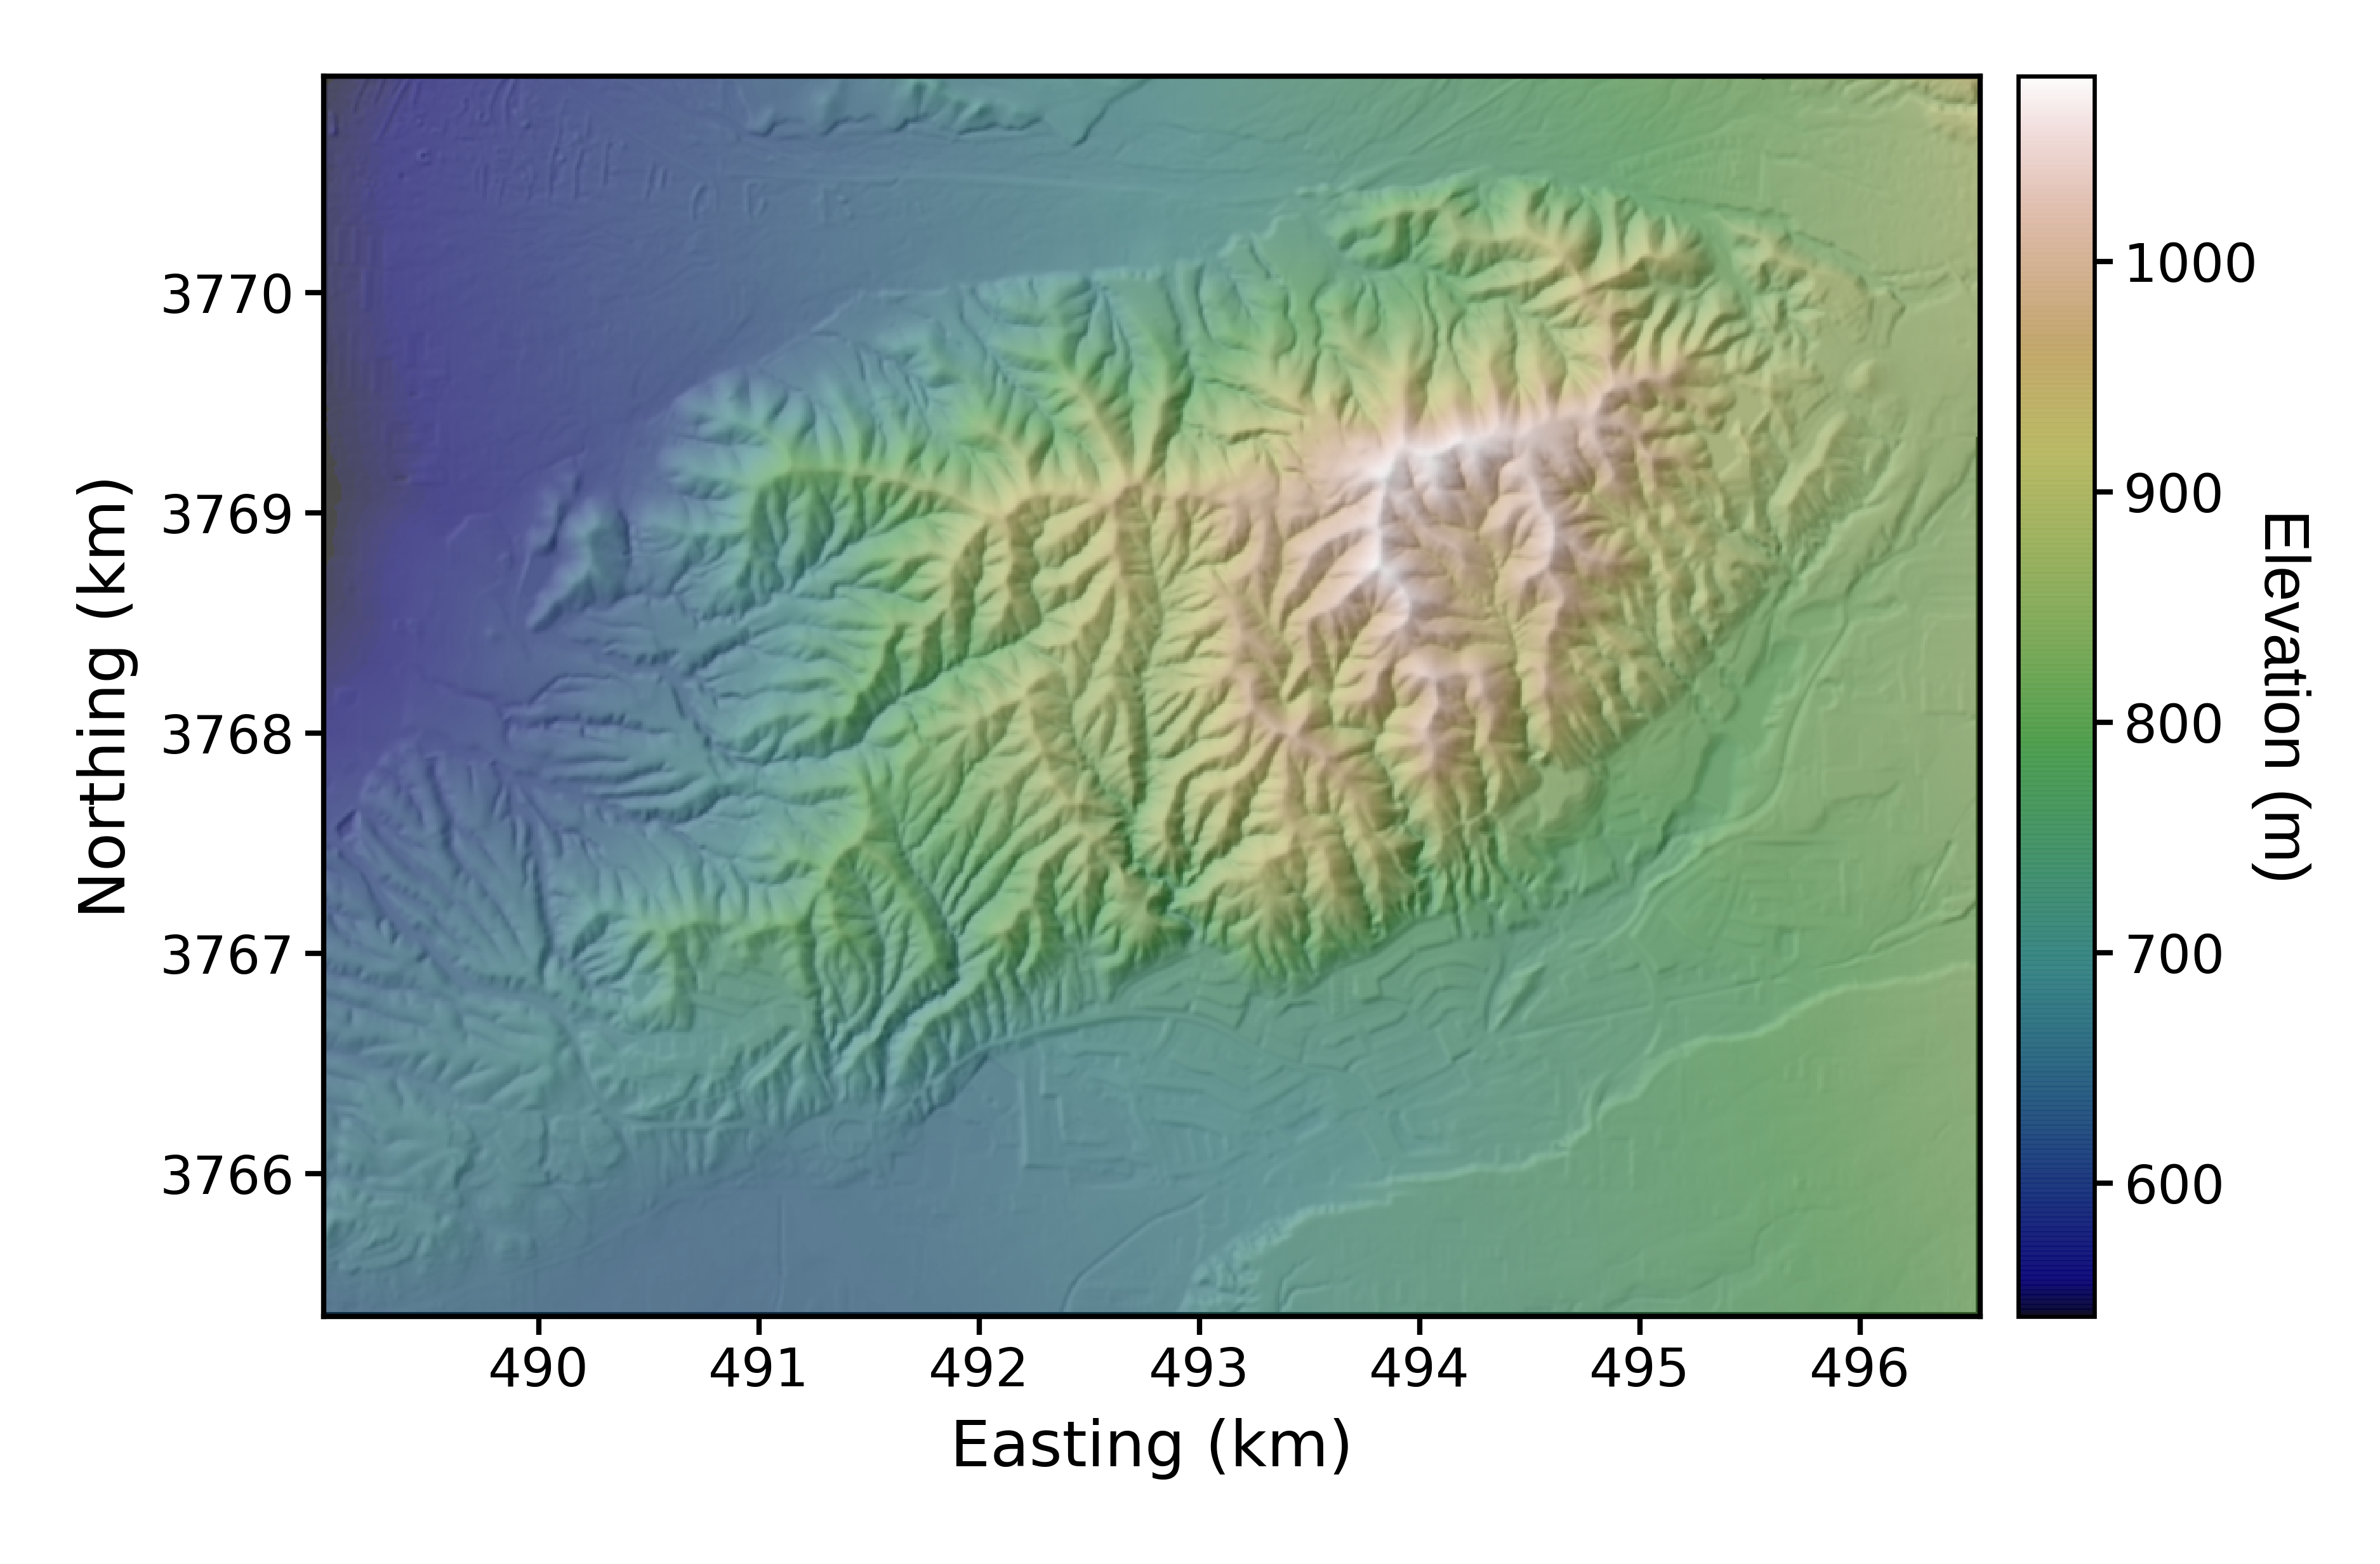

In [21]:
print(this_img)
from IPython.display import display, Image
display(Image(filename=this_img, width=800))